
### Module 2: Regression Model to Predict Bus Arrival Times

Exercise related to material in [AH2179-Exercise 2](https://github.com/zhenliangma/Applied-AI-in-Transportation/tree/main/Exercise_2_regression_model).

In [12]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
sns.set(font_scale=0.5)

In [28]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
count,2179.0,2179.000000,2179.0,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000
mean,10033.0,42255.504819,1.0,216.376319,27.023405,58.164296,200.402478,45.972240
std,0.0,1246.205733,0.0,181.194381,14.103575,7.008233,177.460222,6.517437
min,10033.0,41343.000000,1.0,-72.000000,0.000000,39.000000,-82.000000,27.605263
25%,10033.0,41358.000000,1.0,89.000000,19.000000,51.000000,77.000000,39.390890
50%,10033.0,41373.000000,1.0,175.000000,25.000000,62.000000,159.000000,48.671756
75%,10033.0,44059.000000,1.0,292.000000,33.000000,62.000000,275.500000,50.940968
max,10033.0,45917.000000,1.0,1365.000000,132.000000,103.000000,1364.000000,54.492647


In [18]:
# process arrival time for further features
df['dt'] = df.Arrival_time.apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M'))
df['hour'] = df['dt'].apply(lambda x: x.hour)
df['date'] = df['dt'].dt.date
df['weekday'] = df['dt'].dt.dayofweek

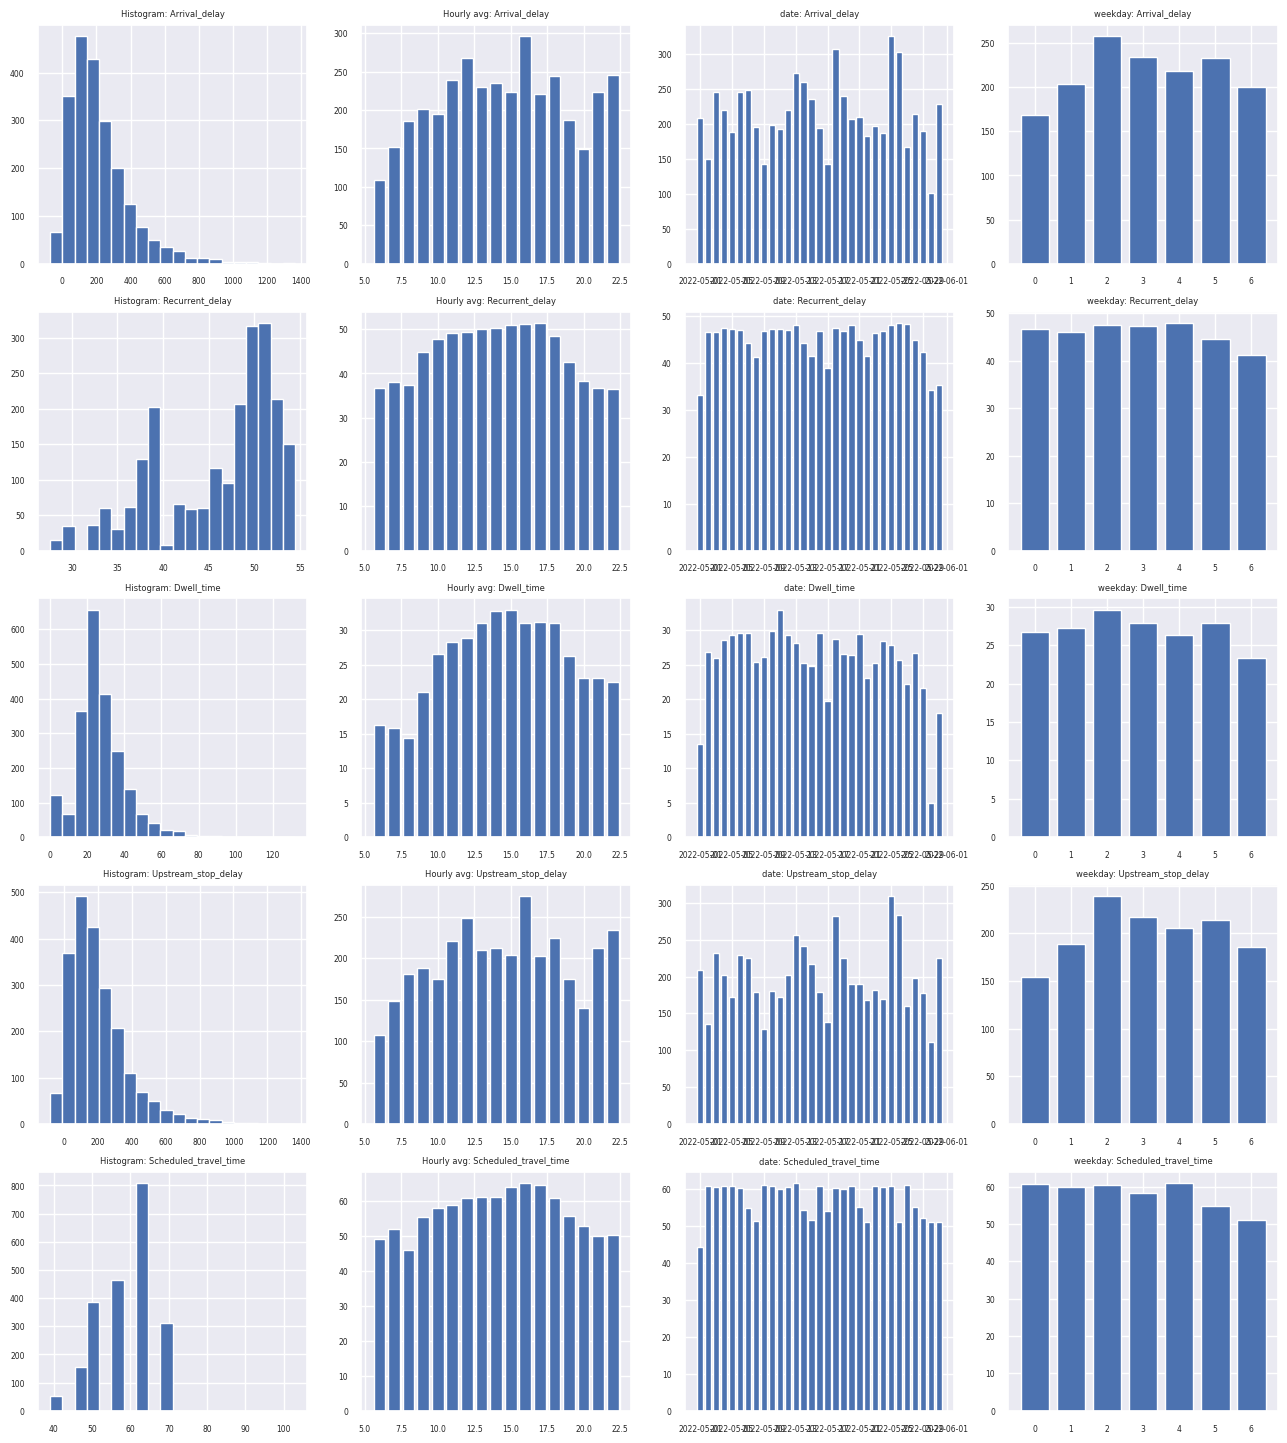

In [19]:
fig, ax = plt.subplots(5, 4, figsize=(16, 18))

for i, e in enumerate(['Arrival_delay', 'Recurrent_delay', 'Dwell_time', 'Upstream_stop_delay', 'Scheduled_travel_time']):
  # histograms
  ax[i,0].hist(df[e], bins=20)
  ax[i,0].set_title('Histogram: ' + e)

  # hourly averages
  groupbyhour = df.groupby(['hour'])[e].mean().reset_index()
  ax[i,1].bar(groupbyhour.hour, groupbyhour[e])
  ax[i,1].set_title('Hourly avg: ' + e)

  groupbyhour = df.groupby(['date'])[e].mean().reset_index()
  ax[i,2].bar(groupbyhour.date, groupbyhour[e])
  ax[i,2].set_title('date: ' + e)

  # hourly averages
  groupbyhour = df.groupby(['weekday'])[e].mean().reset_index()
  ax[i,3].bar(groupbyhour.weekday, groupbyhour[e])
  ax[i,3].set_title('weekday: ' + e)

plt.show()

In [27]:
# create new attributes from existing ones
df['upstream_delay_incl_dwell'] = df['Upstream_stop_delay'] + df['Dwell_time']
df['arrival_time_s'] = df['dt'].astype('int64') // 10**9
df['arrival_time_incl_avgdelay'] = df['arrival_time_s'] + df['Recurrent_delay']

# filter out unneeded attributes
df_filtered = df[['upstream_delay_incl_dwell', 'arrival_time_incl_avgdelay', 'arrival_time_s', 'Arrival_delay', 'Recurrent_delay', 'Dwell_time', 'Upstream_stop_delay', 'Scheduled_travel_time', 'hour', 'weekday']]
df_filtered = df_filtered.dropna()

# show correlation matrix
corr_matrix = df_filtered.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

,Arrival_delay
Arrival_delay,1.000000
upstream_delay_incl_dwell,0.996968
Upstream_stop_delay,0.993935
Dwell_time,0.218745
Recurrent_delay,0.162692
Scheduled_travel_time,0.100695
hour,0.058081
weekday,0.049933
arrival_time_incl_avgdelay,0.035076
arrival_time_s,0.035074


In [29]:
# subset of features to be used
columns_to_scale= ['upstream_delay_incl_dwell']
columns_to_encode = ['weekday']

# divide data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_filtered[columns_to_scale + columns_to_encode], df_filtered['Arrival_delay'], test_size=0.2, random_state=42)

# scale and encode columns accordingly
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

X_train_scaled_columns  = scaler.fit_transform(X_train[columns_to_scale])
X_train_encoded_columns = ohe.fit_transform(X_train[columns_to_encode])

X_test_scaled_columns  = scaler.transform(X_test[columns_to_scale])
X_test_encoded_columns = ohe.transform(X_test[columns_to_encode])

X_train_processed = np.concatenate([X_train_scaled_columns, X_train_encoded_columns], axis=1)
X_test_processed = np.concatenate([X_test_scaled_columns, X_test_encoded_columns], axis=1)


# Define a parameter grid for hyperparameter tuning
param_grid = {
  'eta': [0.075, 0.1], # learning rate
  'gamma': [5, 6, 7], # minimum loss reduction for partition
  'max_depth':	[3, 4, 5], # maximum depth of a tree
  'min_child_weight':	[0], # minimum sum of weights of observations required in a child
  'subsample':	[0.75, 0.8, 1], # subsample ratio of the training instances
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=5, verbose=2) #cv = cross-validation

# Fit the grid search to the scaled training data
grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.75; total time=   1.9s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.75; total time=   0.2s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.75; total time=   0.1s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.75; total time=   0.7s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.75; total time=   0.2s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.8; total time=   0.2s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.8; total time=   0.6s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.8; total time=   0.2s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsample=0.8; total time=   0.1s
[CV] END eta=0.075, gamma=5, max_depth=3, min_child_weight=0, subsamp

Mean Absolute Error: 10.27076089163439
Mean Squared Error: 201.84976661412873
R-squared: 0.993231051433797


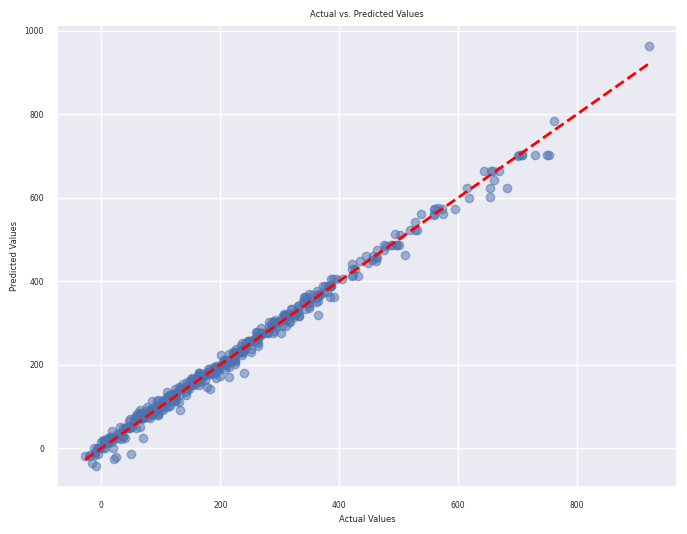

In [30]:
# train model
best_xgb = xgb.XGBRegressor(eta=best_params['eta'], gamma=best_params['gamma'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'], subsample=best_params['subsample'])
best_xgb.fit(X_train, y_train)

# predict and calculate accuracy
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# plot predicted vs actual output
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()